In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [182]:
df = pd.read_csv('demand.csv')
df.head()
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index , format='%m/%d/%Y %H:%M')
df = df.rename(columns={ 'actual_performance(10000 kW)': 'demand'})

In [191]:
# Start from the df as the base
merged_df = df.copy()

# Merge each city’s dataframe on datetime
for prefecture, p_df in prefectures_dfs.items():
    merged_df = pd.merge(
        merged_df, p_df, 
        on='datetime', 
        how='left',
        left_index = True,
        right_index = True
    )

MergeError: Can only pass argument "on" OR "left_index" and "right_index", not a combination of both.

In [188]:
from sklearn.preprocessing import LabelEncoder

for prefecture in prefectures.keys():
    col = f'{prefecture}_wind_direction'
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[col] = le.fit_transform(merged_df[col].astype(str))

In [189]:
# df = merged_df.copy()
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   datetime                            26280 non-null  datetime64[ns]
 1   wakayama_precipitation_x            26280 non-null  float64       
 2   wakayama_temperature_x              26280 non-null  float64       
 3   wakayama_dew_point_temperature_x    26280 non-null  float64       
 4   wakayama_humidity_x                 26280 non-null  float64       
 5   wakayama_wind_speed_x               26280 non-null  float64       
 6   wakayama_wind_direction_x           26280 non-null  object        
 7   wakayama_snowfall_x                 26280 non-null  float64       
 8   osaka_precipitation                 26280 non-null  float64       
 9   osaka_temperature                   26280 non-null  float64       
 10  osaka_dew_point_temper

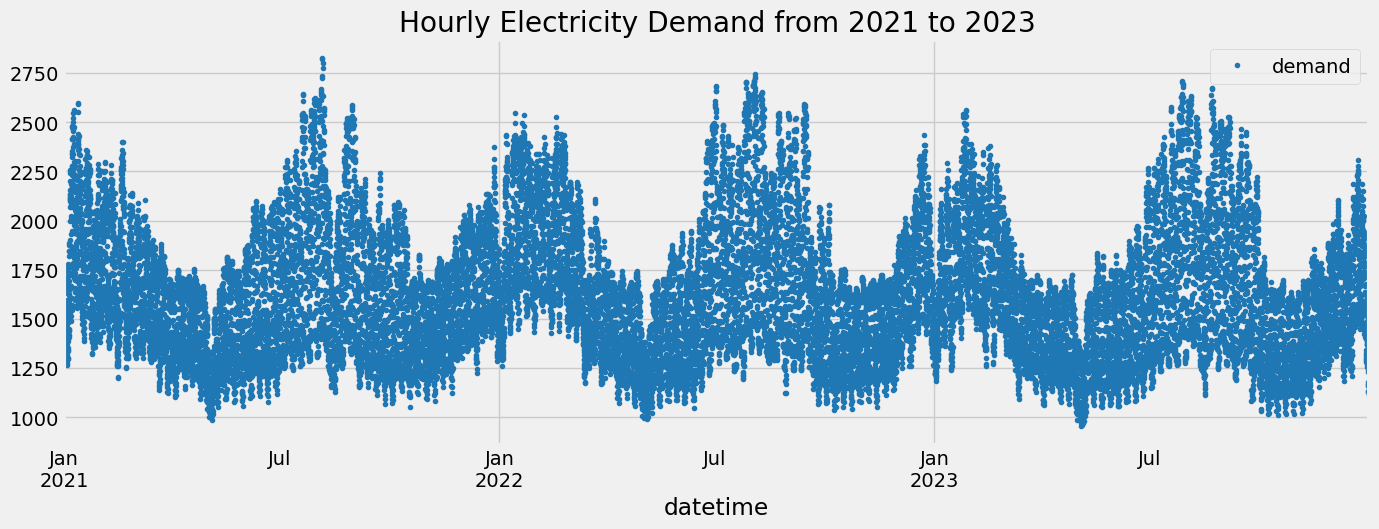

In [51]:
df.plot(style = '.', figsize = (15,5), color= color_pal[0], title = 'Hourly Electricity Demand from 2021 to 2023')
plt.show()

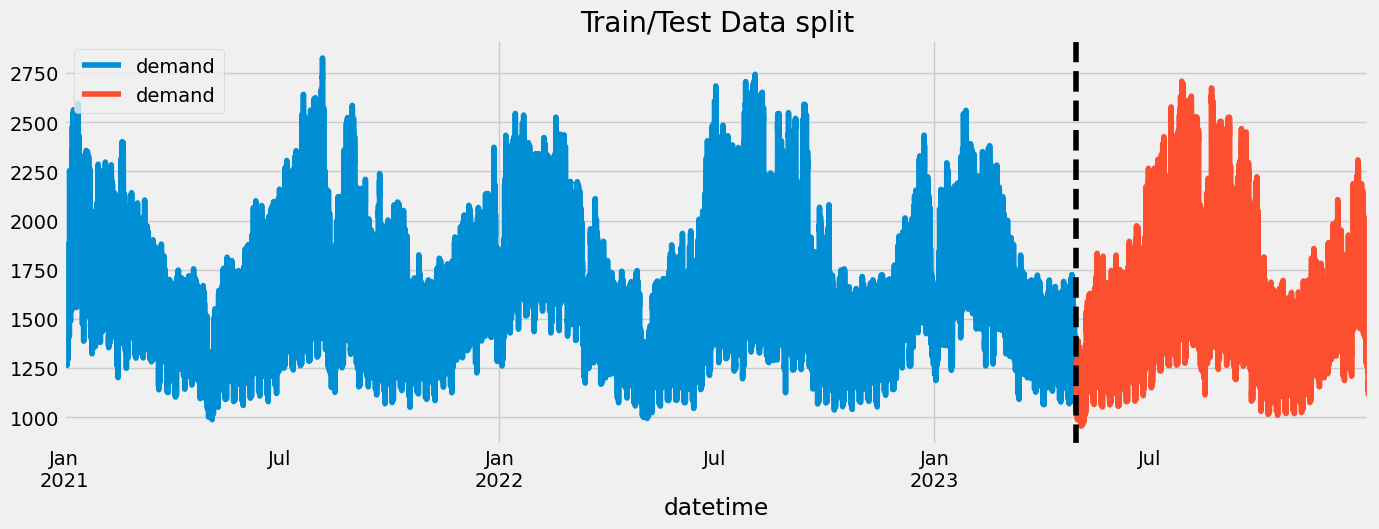

In [52]:
#Train/Test split

train = df.loc[df.index <= '04-30-2023']
test = df.loc[df.index > '04-30-2023']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training Set', title = 'Train/Test Data split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('04-30-2023', color = 'black', ls = '--')
plt.show()

<Axes: title={'center': 'Data of a week'}, xlabel='datetime'>

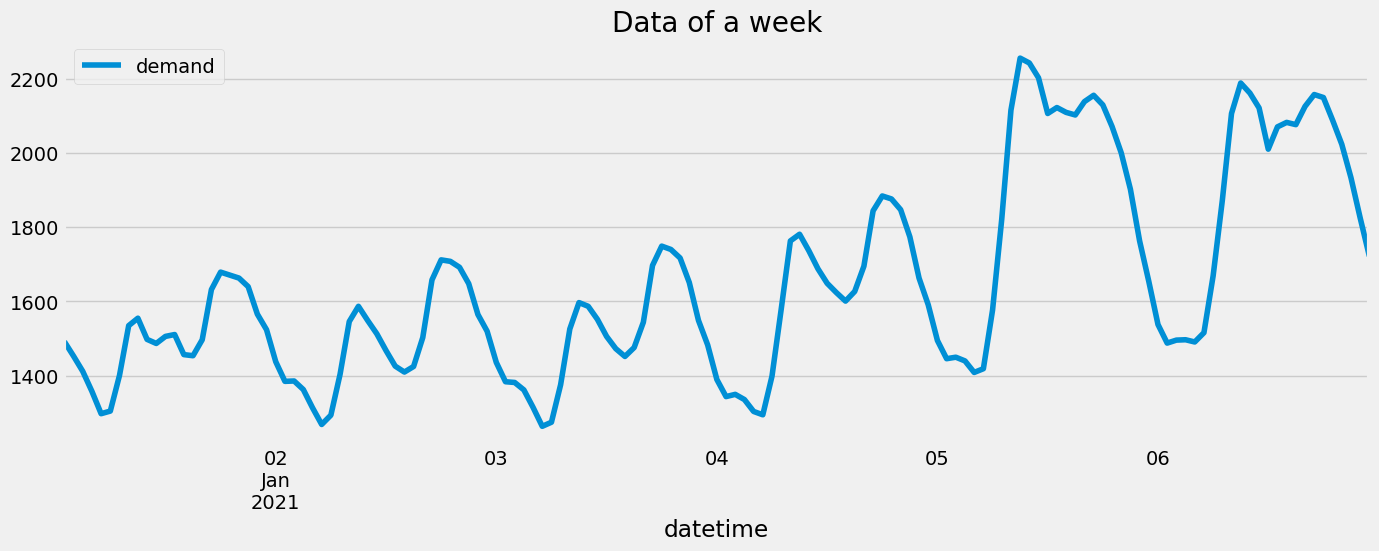

In [53]:
df.loc[(df.index > '01-01-2021') & (df.index < '01-07-2021')].plot(figsize = (15,5), title = 'Data of a week')

In [59]:
#Feature Creation
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

Text(0.5, 1.0, 'Demand by Hour')

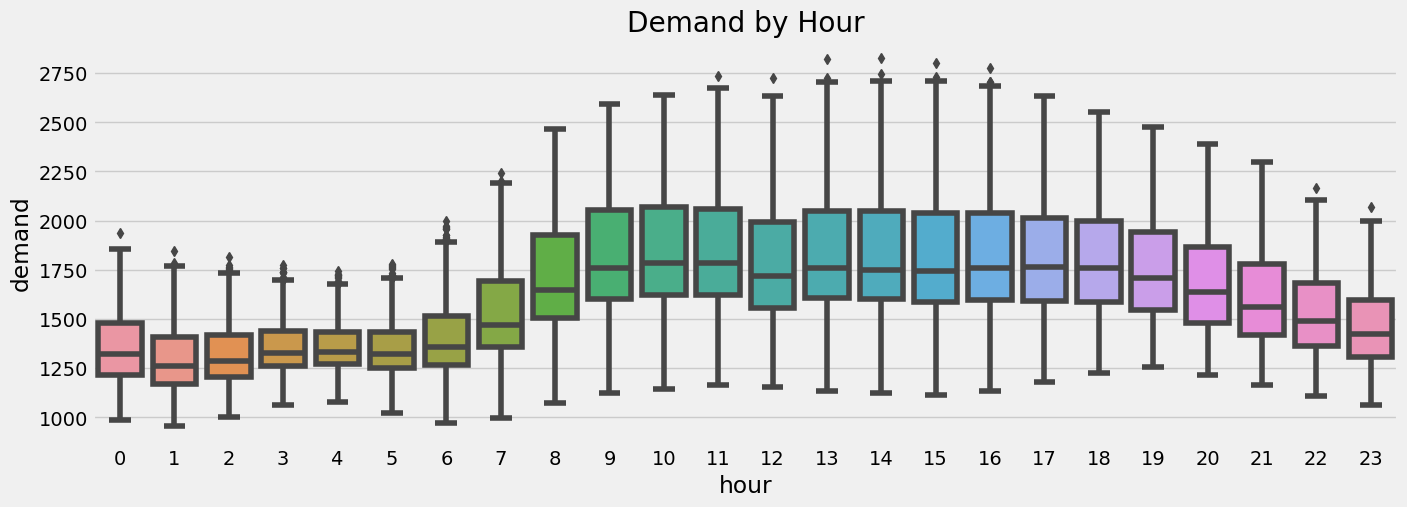

In [57]:
#Visualise the Feature/Target Relationship
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'hour', y='demand')
ax.set_title('Demand by Hour')

Text(0.5, 1.0, 'Demand by month')

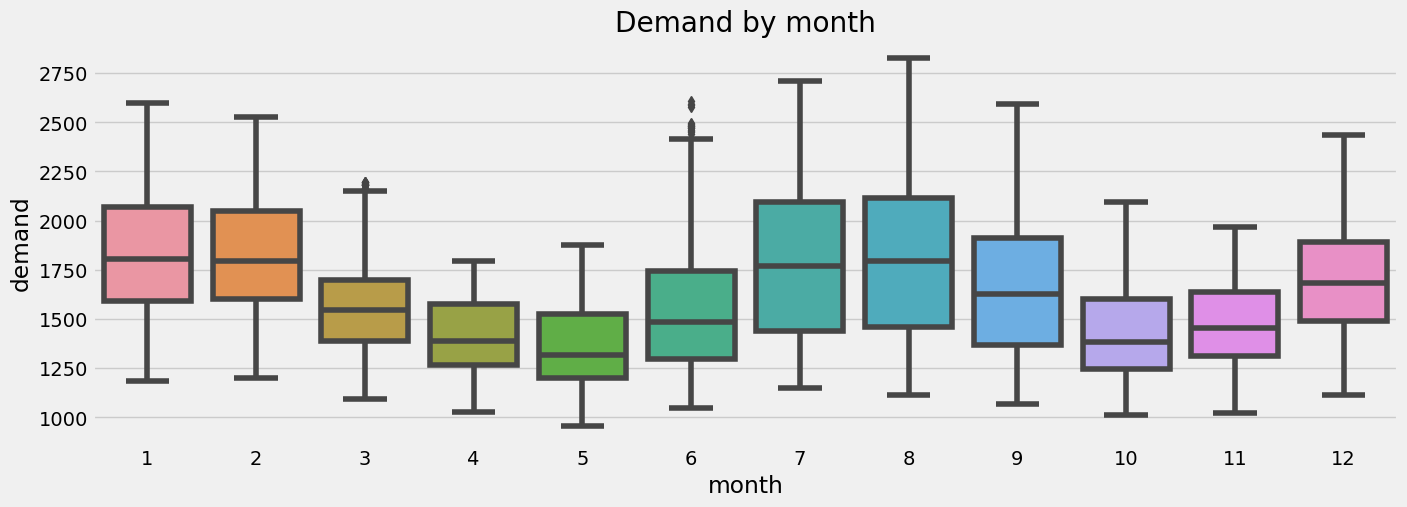

In [58]:
#Visualise the Feature/Target Relationship
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y='demand')
ax.set_title('Demand by month')

In [64]:
#Creating our Model

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'demand'

In [65]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]


In [69]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 10)

[0]	validation_0-rmse:319.71252	validation_1-rmse:346.11040
[10]	validation_0-rmse:296.17947	validation_1-rmse:323.11636
[20]	validation_0-rmse:275.39397	validation_1-rmse:302.94221
[30]	validation_0-rmse:257.00549	validation_1-rmse:285.13907
[40]	validation_0-rmse:240.76180	validation_1-rmse:269.46837
[50]	validation_0-rmse:226.43251	validation_1-rmse:255.75496
[60]	validation_0-rmse:213.77099	validation_1-rmse:243.73809
[70]	validation_0-rmse:202.57149	validation_1-rmse:232.94234
[80]	validation_0-rmse:192.72568	validation_1-rmse:223.48132
[90]	validation_0-rmse:184.11200	validation_1-rmse:215.17454
[100]	validation_0-rmse:176.39660	validation_1-rmse:207.75109
[110]	validation_0-rmse:169.47077	validation_1-rmse:201.04711
[120]	validation_0-rmse:163.10373	validation_1-rmse:194.40292
[130]	validation_0-rmse:157.48227	validation_1-rmse:188.40648
[140]	validation_0-rmse:152.28154	validation_1-rmse:183.03098
[150]	validation_0-rmse:147.50166	validation_1-rmse:178.23505
[160]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

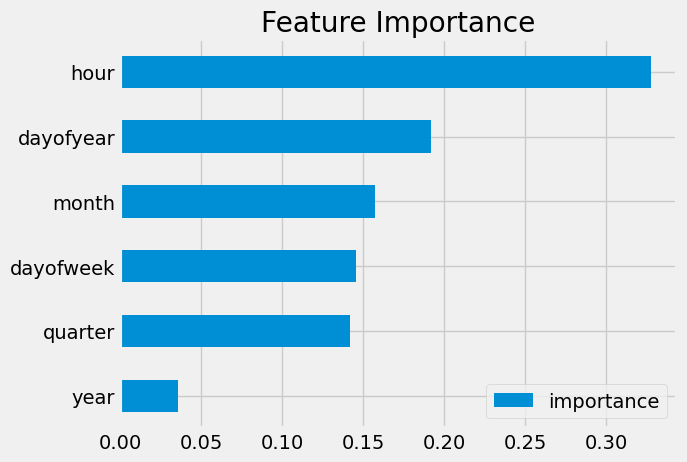

In [71]:
fimp = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['importance'])

fimp.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [76]:
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw Data and Predicted Data')

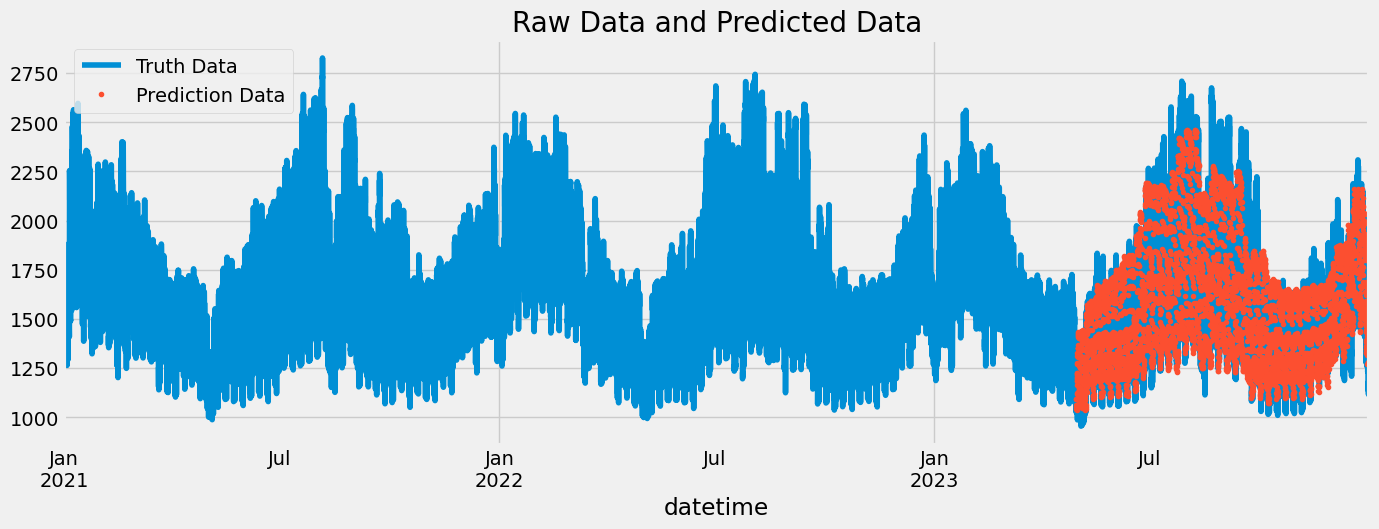

In [79]:
ax = df['demand'].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Raw Data and Predicted Data')

Text(0.5, 1.0, 'Data of a week')

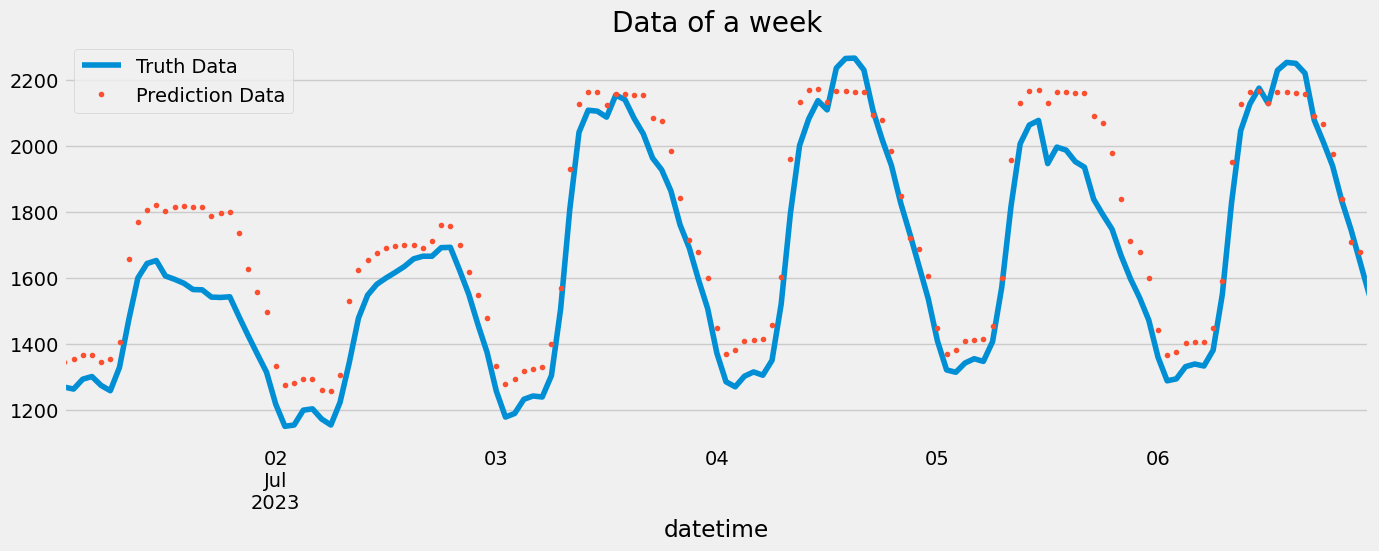

In [88]:
ax = df.loc[(df.index > '07-01-2023') & (df.index < '07-07-2023')]['demand'].plot(figsize = (15,5))
df.loc[(df.index > '07-01-2023') & (df.index < '07-07-2023')]['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Data of a week')

In [89]:
score = np.sqrt(mean_squared_error(test['demand'], test['prediction']))
print(f'RMSE score on Test set : {score:0.2f}')

RMSE score on Test set : 116.71


In [96]:
test['error']   = np.abs(test[TARGET] -test['prediction'])

test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

date
2023-05-08    11.931595
2023-05-09    14.092656
2023-06-11    14.155558
2023-05-20    17.020452
2023-05-14    18.259898
Name: error, dtype: float64

In [135]:
import jpholiday
from sklearn.model_selection import train_test_split

# Create comprehensive holiday features
def create_holiday_features(df):

    df = df.copy()
    
    # Basic holiday indicators
    df['is_holiday'] = df.index.map(lambda x: jpholiday.is_holiday(x)).astype(int)
    df['is_weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
    
    # Advanced holiday proximity features
    df['days_before_holiday'] = 0
    df['days_after_holiday'] = 0
    
    holidays = jpholiday.between(df.index.min(), df.index.max())
    
    for date in [h[0] for h in holidays]:
        # Days before holiday
        prev_day = date - pd.Timedelta(days=1)
        if prev_day in df.index:
            df.loc[prev_day, 'days_before_holiday'] += 1
            
        # Days after holiday
        next_day = date + pd.Timedelta(days=1)
        if next_day in df.index:
            df.loc[next_day, 'days_after_holiday'] += 1
            
    # Holiday type encoding
    df['holiday_type'] = df.index.map(lambda x: jpholiday.is_holiday_name(x) or 'non_holiday')
    df = pd.get_dummies(df, columns=['holiday_type'], prefix='holiday', dummy_na=False)
    
    return df

df_with_hols = create_holiday_features(df)


In [136]:
df_with_hols = df_with_hols.drop(columns = ['prediction'])
df_with_hols

,demand,hour,dayofweek,quarter,month,year,dayofyear,is_holiday,is_weekend,days_before_holiday,...,holiday_山の日 振替休日,holiday_建国記念の日,holiday_憲法記念日,holiday_成人の日,holiday_敬老の日,holiday_文化の日,holiday_春分の日,holiday_昭和の日,holiday_海の日,holiday_秋分の日
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1571,0,4,1,1,2021,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2021-01-01 01:00:00,1492,1,4,1,1,2021,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2021-01-01 02:00:00,1453,2,4,1,1,2021,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2021-01-01 03:00:00,1412,3,4,1,1,2021,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2021-01-01 04:00:00,1358,4,4,1,1,2021,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,1427,19,6,4,12,2023,365,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2023-12-31 20:00:00,1392,20,6,4,12,2023,365,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2023-12-31 21:00:00,1348,21,6,4,12,2023,365,0,1,0,...,False,False,False,False,False,False,False,False,False,False


In [163]:
train = df.loc[df.index <= '04-30-2023']
test = df.loc[df.index > '04-30-2023']
train = create_features(train)
test = create_features(test)
train_with_hols = create_holiday_features(train)
test_with_hols = create_holiday_features(test)
test_with_hols = test_with_hols.drop(columns = ['prediction'])

In [164]:
print(test_with_hols.info())
print(train_with_hols.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5903 entries, 2023-04-30 01:00:00 to 2023-12-31 23:00:00
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   demand               5903 non-null   int64
 1   hour                 5903 non-null   int32
 2   dayofweek            5903 non-null   int32
 3   quarter              5903 non-null   int32
 4   month                5903 non-null   int32
 5   year                 5903 non-null   int32
 6   dayofyear            5903 non-null   int32
 7   is_holiday           5903 non-null   int32
 8   is_weekend           5903 non-null   int32
 9   days_before_holiday  5903 non-null   int64
 10  days_after_holiday   5903 non-null   int64
 11  holiday_non_holiday  5903 non-null   bool 
 12  holiday_こどもの日        5903 non-null   bool 
 13  holiday_みどりの日        5903 non-null   bool 
 14  holiday_スポーツの日       5903 non-null   bool 
 15  holiday_勤労感謝の日       5903 non-null  

In [165]:
test_with_hols.columns

Index(['demand', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'is_holiday', 'is_weekend', 'days_before_holiday', 'days_after_holiday',
       'holiday_non_holiday', 'holiday_こどもの日', 'holiday_みどりの日',
       'holiday_スポーツの日', 'holiday_勤労感謝の日', 'holiday_山の日', 'holiday_憲法記念日',
       'holiday_敬老の日', 'holiday_文化の日', 'holiday_海の日', 'holiday_秋分の日'],
      dtype='object')

In [166]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','is_holiday', 'is_weekend']
TARGET = 'demand'

X_train = train_with_hols[FEATURES]
Y_train = train_with_hols[TARGET]

X_test = test_with_hols[FEATURES]
Y_test = test_with_hols[TARGET]

regh = xgb.XGBRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    max_depth=8,  # Increased to capture holiday patterns
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=100
)
regh.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 10)

[0]	validation_0-rmse:320.73582	validation_1-rmse:347.18346
[10]	validation_0-rmse:296.36050	validation_1-rmse:322.38585
[20]	validation_0-rmse:276.18417	validation_1-rmse:302.27167
[30]	validation_0-rmse:255.94775	validation_1-rmse:281.77935
[40]	validation_0-rmse:237.96158	validation_1-rmse:263.52124
[50]	validation_0-rmse:223.06687	validation_1-rmse:248.80095
[60]	validation_0-rmse:208.17553	validation_1-rmse:233.91423
[70]	validation_0-rmse:196.84194	validation_1-rmse:223.18871
[80]	validation_0-rmse:183.83770	validation_1-rmse:210.31412
[90]	validation_0-rmse:172.91039	validation_1-rmse:199.90934
[100]	validation_0-rmse:164.04444	validation_1-rmse:191.83987
[110]	validation_0-rmse:157.17492	validation_1-rmse:185.74072
[120]	validation_0-rmse:149.19629	validation_1-rmse:178.06485
[130]	validation_0-rmse:141.94789	validation_1-rmse:171.57230
[140]	validation_0-rmse:134.63407	validation_1-rmse:164.73477
[150]	validation_0-rmse:127.90889	validation_1-rmse:158.42908
[160]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

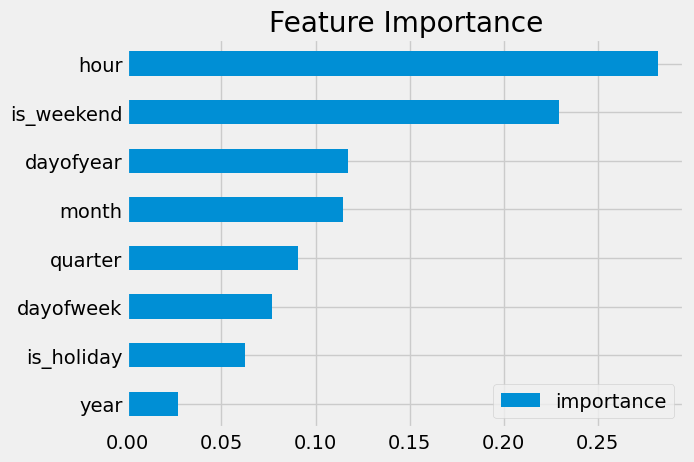

In [167]:
fimph = pd.DataFrame(data = regh.feature_importances_,
            index = regh.feature_names_in_,
            columns = ['importance'])

fimph.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [168]:
test_with_hols['prediction'] = regh.predict(X_test)

df_with_hols = df_with_hols.merge(test_with_hols[['prediction']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw Data and Predicted Data with holidays in consideration')

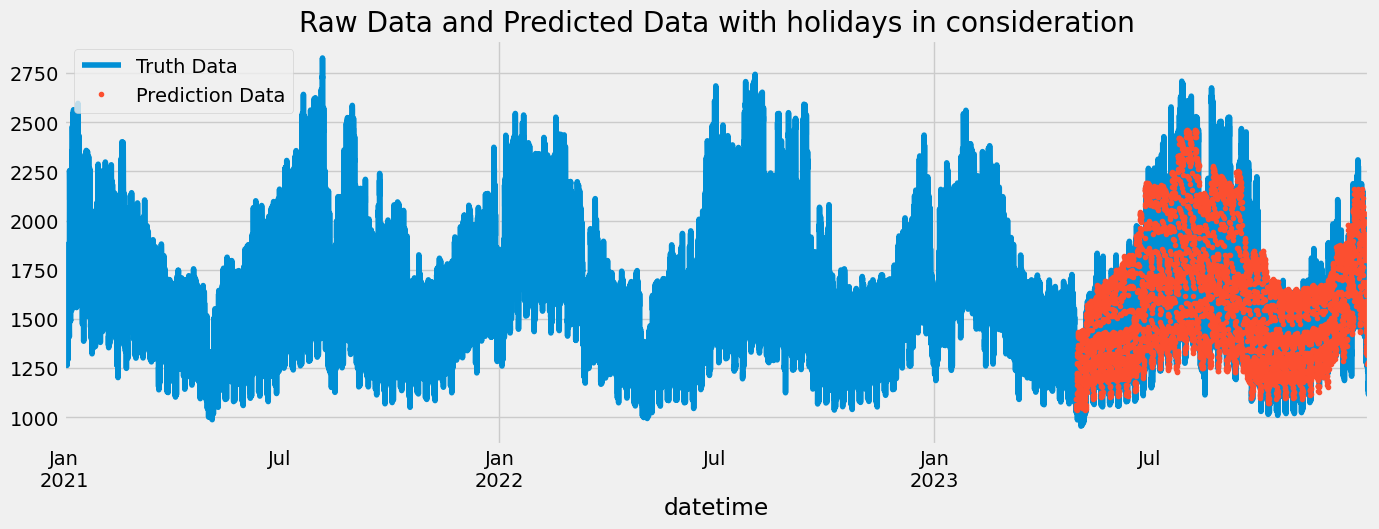

In [171]:
ax = df['demand'].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Raw Data and Predicted Data with holidays in consideration')

Text(0.5, 1.0, 'Data of a week')

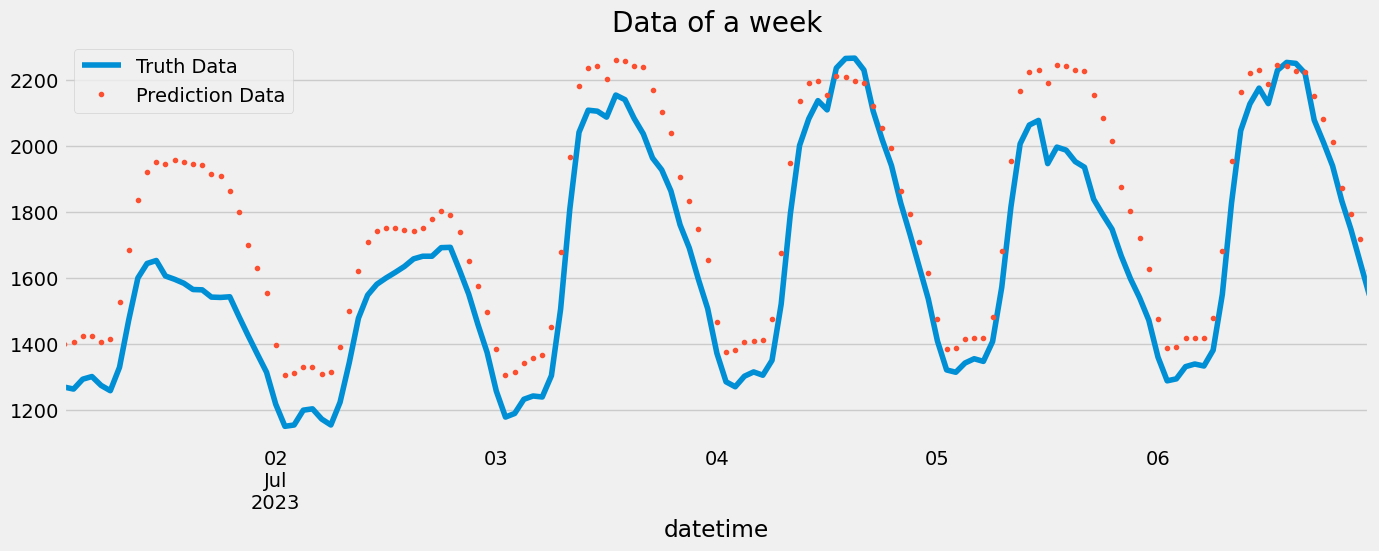

In [170]:
ax = df_with_hols.loc[(df_with_hols.index > '07-01-2023') & (df_with_hols.index < '07-07-2023')]['demand'].plot(figsize = (15,5))
df_with_hols.loc[(df_with_hols.index > '07-01-2023') & (df_with_hols.index < '07-07-2023')]['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Data of a week')

In [173]:
score = np.sqrt(mean_squared_error(test_with_hols['demand'], test_with_hols['prediction']))
print(f'RMSE score on Test set(/w holidays) : {score:0.2f}')

test_with_hols['error'] = np.abs(test_with_hols[TARGET] -test_with_hols['prediction'])

test_with_hols['date'] = test_with_hols.index.date
test_with_hols.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

RMSE score on Test set(/w holidays) : 110.43


date
2023-05-20    12.352900
2023-06-11    16.826711
2023-05-09    17.337321
2023-05-11    17.788961
2023-05-30    19.481557
Name: error, dtype: float64